# Few-Shot Prompting on agnews

- total number of train samples: 1 or 2 per label
- total number of test&nbsp; samples: 500
- model: Casual LM
- dataset: agnews

TESTS:
1. DeepSeek-R1-Distill-Qwen-1.5B - 1ex per label
2. DeepSeek-R1-Distill-Qwen-1.5B - 2ex per label
3. Llama-2-7b-hf - 1ex per label
4. Llama-2-7b-hf - 2ex per label

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoModelForCausalLM, AutoTokenizer, LlamaTokenizer, LlamaForCausalLM, BitsAndBytesConfig

# CHANGE WORKING DIRECTORY TO ROOT
current_dir = os.path.basename(os.getcwd())
if current_dir == "src":
    os.chdir("..") # Move up by 1
elif os.path.basename(os.getcwd()) == "bai-thesis-nlp":  
    pass # If already at root, stay there
else:
    os.chdir("../..") # Move up by 2 otherwise
     
from src._utils._run_fewshotCasualLM import main_fewshot_classification
from src._utils._helpers import log_synthetic_data, response2json, get_response, set_seed, clear_cuda_cache, get_generated_examples_df

In [3]:
FOLDER_DIR = "src/agnews/experiments/fewshotCasualLM_500samples"
os.makedirs(FOLDER_DIR, exist_ok=True)
LOG_DIR = os.path.join(FOLDER_DIR, "fewshotCasualLM.json")

### LOAD DATA ###
# real data
real_train_df = pd.read_csv("real_data/train/agnewstrainAll.csv").rename(columns={"2": "text", "3": "label"})
real_train_df.drop(columns=["0", "1"], inplace=True)

# # Take 500 samples for dev set
# real_train_df, dev_df = train_test_split(real_train_df, test_size=500, random_state=42, stratify=real_train_df["label"])
# # Store the dev set into a CSV file
# dev_df.to_csv(os.path.join(FOLDER_DIR, "dev_set.csv"), index=False)

dev_df = pd.read_csv("src/agnews/experiments/RoBERTA_500samples/dev_set.csv")
model = None

In [ ]:
def get_results(details):
    """Just get useful results from the details"""
    res = details["metrics_test"]
    res["method"] = details["output_file"].split("/")[-1].replace("fewshot_", "").replace(".csv", "")
    res["time_taken_seconds"] = details["time_taken_seconds"]
    
    df = pd.DataFrame([res])
    new_order = ["method"] + [col for col in df.columns if col != "method"]
    df = df[new_order]
    display(df.round(3))
    return df

def get_n_examples_per_label(df, n):
    return df.groupby('label')[['text', 'label']].apply(
                lambda x: x.sample(n, random_state=42)
            ).reset_index(drop=True)

# take n examples per label
_1ex_perlabel = get_n_examples_per_label(real_train_df, 1)

_2ex_perlabel = get_n_examples_per_label(real_train_df, 2)

print("1 example per label")
display(_1ex_perlabel)
print("2 examples per label")
display(_2ex_perlabel)

1 example per label


,text,label
0,Wal-Mart amasses more data about the products ...,Business
1,"AP - Three-dimensional movies at home, without...",Sci/Tech
2,World number one Roger Federer was stretched t...,Sports
3,Rebels blew up a pipeline inside an oilfield i...,World


2 examples per label


,text,label
0,Wal-Mart amasses more data about the products ...,Business
1,Business Week has reached outside its own rank...,Business
2,"AP - Three-dimensional movies at home, without...",Sci/Tech
3,Low initial shipment figures for Sony #39;s fo...,Sci/Tech
4,World number one Roger Federer was stretched t...,Sports
5,MILTON -- If you could build a prototype Mansf...,Sports
6,Rebels blew up a pipeline inside an oilfield i...,World
7,"SEOUL, South Korea - A huge mushroom cloud tha...",World


# 1. DeepSeek-R1-Distill-Qwen-1.5B - 1ex per label

In [12]:
if model:
    clear_cuda_cache(model)

model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    attn_implementation='flash_attention_2',
    quantization_config=quantization_config,
    low_cpu_mem_usage=True
).to("cuda")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.generation_config.pad_token_id = tokenizer.pad_token_id

In [13]:
results = []
instruction = "Classify the following texts into one of the given categories"
name = "fewshot_deepseek_1ex4label.csv"

config = {
    "dataset_name": "agnews",
    "experiment_name": "fewshot_classification",
    "fewshot_df": _1ex_perlabel,
    "test_df": dev_df,
    "instruction": instruction,
    "model": model,
    "tokenizer": tokenizer,
    "output_file": os.path.join(FOLDER_DIR, name),
    "log_file": LOG_DIR,
    "seed": 42,
}

details = main_fewshot_classification(config)
results.append(get_results(details))


🚀 Starting Few-Shot Classification
📊 Dataset         : agnews
📚 Experiment      : fewshot_classification
🤖 Model           : deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B
💾 Output File     : src/agnews/experiments/fewshotCasualLM_500samples/fewshot_deepseek_1ex4label.csv
🎯 Seed            : 42



Processing examples: 100%|██████████| 500/500 [01:36<00:00,  5.20it/s]


📝 Log saved successfully to: src/agnews/experiments/fewshotCasualLM_500samples/fewshotCasualLM.json
💾 Predictions saved to: src/agnews/experiments/fewshotCasualLM_500samples/fewshot_deepseek_1ex4label.csv


,method,f1_micro,f1_macro,accuracy,time_taken_seconds
0,deepseek_1ex4label,0.472,0.437,0.472,96.11


In [14]:
df_res = pd.read_csv(config["output_file"])
display(df_res.head())

,text,label,predicted_label
0,"NEW DELHI, SEPTEMBER 17: The Cabinet today app...",World,Business
1,In LONDON story headlined quot;Van Nistelrooy...,Sports,World
2,A new report from Congress #39; research arm a...,Business,Sci/Tech
3,The head of the U.N. nuclear watchdog agency s...,World,Business
4,A years-long phenomenon continues as crowds ga...,Sci/Tech,Business


# 2. DeepSeek-R1-Distill-Qwen-1.5B - 2ex per label

In [15]:
name = "fewshot_deepseek_2ex4label.csv"

config = {
    "dataset_name": "agnews",
    "experiment_name": "fewshot_classification",
    "fewshot_df": _2ex_perlabel,
    "test_df": dev_df,
    "instruction": instruction,
    "model": model,
    "tokenizer": tokenizer,
    "output_file": os.path.join(FOLDER_DIR, name),
    "log_file": LOG_DIR,
    "seed": 42,
}

details = main_fewshot_classification(config)
results.append(get_results(details))


🚀 Starting Few-Shot Classification
📊 Dataset         : agnews
📚 Experiment      : fewshot_classification
🤖 Model           : deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B
💾 Output File     : src/agnews/experiments/fewshotCasualLM_500samples/fewshot_deepseek_2ex4label.csv
🎯 Seed            : 42



Processing examples: 100%|██████████| 500/500 [01:45<00:00,  4.74it/s]

📝 Log saved successfully to: src/agnews/experiments/fewshotCasualLM_500samples/fewshotCasualLM.json
💾 Predictions saved to: src/agnews/experiments/fewshotCasualLM_500samples/fewshot_deepseek_2ex4label.csv


,method,f1_micro,f1_macro,accuracy,time_taken_seconds
0,deepseek_2ex4label,0.282,0.254,0.282,105.5


# 3. Llama-2-7b-hf - 1ex per label

In [ ]:
if model:
    clear_cuda_cache(model)

quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)
model_name = "meta-llama/Llama-2-7b-hf"
token = ''
model = LlamaForCausalLM.from_pretrained(
            model_name, 
            token=token,
            torch_dtype=torch.float16,
            attn_implementation='flash_attention_2',
            quantization_config=quantization_config,
            low_cpu_mem_usage=True
        ).to("cuda")

tokenizer = LlamaTokenizer.from_pretrained(model_name, token=token)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
name = "fewshot_llama2_1ex4label.csv"

config = {
    "dataset_name": "agnews",
    "experiment_name": "fewshot_classification",
    "fewshot_df": _1ex_perlabel,
    "test_df": dev_df,
    "instruction": instruction,
    "model": model,
    "tokenizer": tokenizer,
    "output_file": os.path.join(FOLDER_DIR, name),
    "log_file": LOG_DIR,
    "seed": 42,
}

details = main_fewshot_classification(config)
results.append(get_results(details))


🚀 Starting Few-Shot Classification
📊 Dataset         : agnews
📚 Experiment      : fewshot_classification
🤖 Model           : meta-llama/Llama-2-7b-hf
💾 Output File     : src/agnews/experiments/fewshotCasualLM_500samples/fewshot_llama2_1ex4label.csv
🎯 Seed            : 42



Processing examples: 100%|██████████| 500/500 [04:03<00:00,  2.06it/s]

📝 Log saved successfully to: src/agnews/experiments/fewshotCasualLM_500samples/fewshotCasualLM.json
💾 Predictions saved to: src/agnews/experiments/fewshotCasualLM_500samples/fewshot_llama2_1ex4label.csv


,method,f1_micro,f1_macro,accuracy,time_taken_seconds
0,llama2_1ex4label,0.668,0.433,0.668,243.17


# 4. Llama-2-7b-hf - 2ex per label

In [18]:
name = "fewshot_llama2_2ex4label.csv"

config = {
    "dataset_name": "agnews",
    "experiment_name": "fewshot_classification",
    "fewshot_df": _2ex_perlabel,
    "test_df": dev_df,
    "instruction": instruction,
    "model": model,
    "tokenizer": tokenizer,
    "output_file": os.path.join(FOLDER_DIR, name),
    "log_file": LOG_DIR,
    "seed": 42,
}

details = main_fewshot_classification(config)
results.append(get_results(details))


🚀 Starting Few-Shot Classification
📊 Dataset         : agnews
📚 Experiment      : fewshot_classification
🤖 Model           : meta-llama/Llama-2-7b-hf
💾 Output File     : src/agnews/experiments/fewshotCasualLM_500samples/fewshot_llama2_2ex4label.csv
🎯 Seed            : 42



Processing examples: 100%|██████████| 500/500 [04:30<00:00,  1.85it/s]

📝 Log saved successfully to: src/agnews/experiments/fewshotCasualLM_500samples/fewshotCasualLM.json
💾 Predictions saved to: src/agnews/experiments/fewshotCasualLM_500samples/fewshot_llama2_2ex4label.csv


,method,f1_micro,f1_macro,accuracy,time_taken_seconds
0,llama2_2ex4label,0.834,0.53,0.834,270.8


# Results

In [24]:
df_results = pd.concat(results)
df_results.to_csv(os.path.join(FOLDER_DIR, "fewshotCasualLM_results_dev.csv"), index=False)
display(df_results.round(3))

,method,f1_micro,f1_macro,accuracy,time_taken_seconds
0,deepseek_1ex4label,0.472,0.437,0.472,96.11
0,deepseek_2ex4label,0.282,0.254,0.282,105.50
0,llama2_1ex4label,0.668,0.433,0.668,243.17
0,llama2_2ex4label,0.834,0.530,0.834,270.80


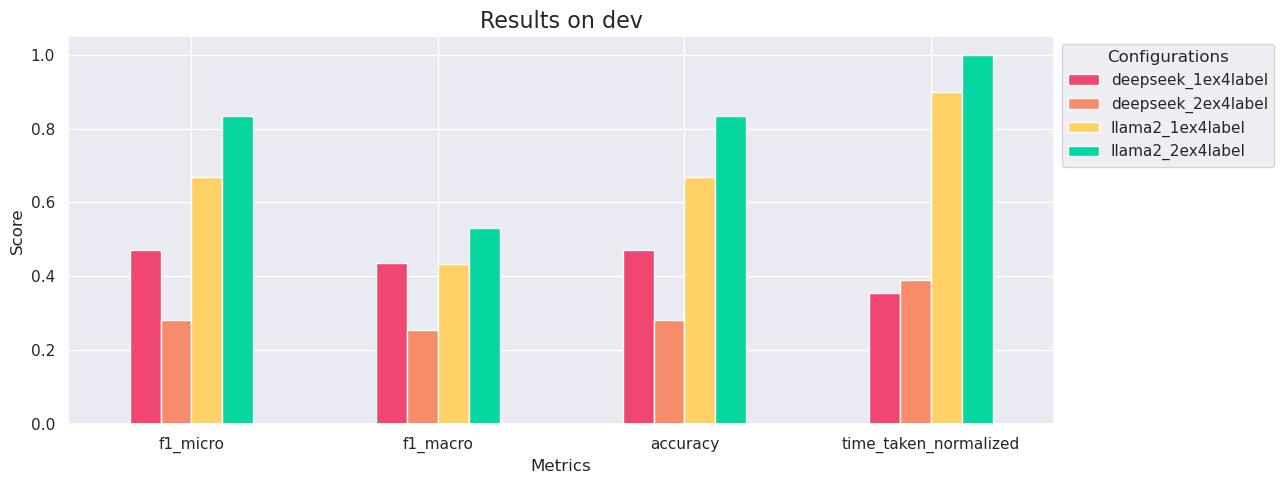

In [27]:
# df_results = pd.read_csv(os.path.join(FOLDER_DIR, "fewshotCasualLM_results_dev.csv"))

plot_df = df_results.set_index('method')
plot_df["time_taken_normalized"] = plot_df["time_taken_seconds"] / max(plot_df["time_taken_seconds"])
plot_df.drop(columns=["time_taken_seconds"], inplace=True)
colors = ['#ef476f', '#f78c6b', '#ffd166', '#06d6a0', '#118ab2', '#073b4c', '#aaaaaa']
ax = plot_df.T.plot(kind='bar', figsize=(13, 5), color=colors)

plt.title('Results on dev', fontsize=16)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Configurations', bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()